# Extract Average Depth Data Mixed Heating

In [1]:
%matplotlib inline

import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal

%config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 350
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 1.

## Functions

In [2]:
def org_T_and_V(array,procZ):
    # obtain important array data
    lol = pd.DataFrame(array)
    lrow,lcol = lol.shape
    n = np.linspace(0,1,procZ+1)
    # prepare dictionary
    dates_list = [dt.datetime(2015,11,i+1) for i in range(procZ)]
    month_day_list = [d.strftime("%m%d") for d in dates_list]

    dataframe_collection = {} 
    i = 0

    for month_day in month_day_list:
        dataframe_collection[month_day] = lol.iloc[:,int(lcol*n[i]):int(lcol*(n[i+1]))].T.reset_index(drop=True).T
        i = i + 1
        
    Data = pd.concat(dataframe_collection.values(),ignore_index = True).reset_index(drop=True)
        
    for i in range(procZ-1):
        Data = Data.drop(Data.index[int((i+1)*(lrow-1))]).reset_index(drop=True)
      
    tempNumpy = Data.to_numpy()
    return tempNumpy

In [3]:
def profile_averages(Tarray,Varray,pts):
    Tave = np.mean(Tarray[:,pts::],axis=1)
    Vave = np.mean(Varray[:,pts::],axis=1)    
    return Tave,Vave

def compute_nua(meta, pts):
    nut=np.mean(meta[2,pts:])
    nub=np.mean(meta[3,pts:])
    return nut, nub

def get_short_inds(procZ,inds,Tarray):
    lrow,lcol = Tarray.shape
    inds2 = inds[inds<lcol]
    return inds2

def statSteadSate(y):
    y = pd.DataFrame(y)
    count1 = len(y)
    aveWindow = int(np.floor(count1/3))
    varWindow = int(np.floor(count1/10))
    rolave = y.rolling(window=aveWindow,min_periods=varWindow).mean()
    rolstd = y.rolling(window=aveWindow,min_periods=varWindow).std()
    rolstd2 = (rolstd-rolstd.min())/(rolstd.max()-rolstd.min()) #normalize
    d = rolstd*100/rolave
    dlen = len(d)
    dave = d[0:int(np.floor(dlen/3))].mean()
    idxs = np.where(rolstd2<0.05)
    idx = idxs[0][0]
    return idx

def rmsValue(arr):
    n = len(arr)
    square = 0
    mean = 0.0
    root = 0.0     
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)     
    #Calculate Mean
    mean = (square / (float)(n))     
    #Calculate Root
    root = np.sqrt(mean)     
    return root

## Process output data

### Load Data 

In [4]:
h = 'H50'; ra = '1e8'; modelType = 'ISO'; res = '64';
modelName1= modelType+'Ra'+ra;
model_name=modelName1+'-'+res # just your model name
big_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_MH\\'

model_path_prefix2=big_path + ra  # adjust for where the model data is located
model_path_prefix=big_path + ra + '\\' + h +'\\Case' \
        + model_name+'\\output-'+model_name
full_path = big_path + ra + '\\' + h 

nu_path = big_path + ra

pts=[]

meta = np.genfromtxt(model_path_prefix+'.meta.ave.dat')
temp = np.genfromtxt(model_path_prefix+'.temp.ave.dat')
vrms = np.genfromtxt(model_path_prefix+'.vrms.ave.dat')
z = np.genfromtxt(model_path_prefix2 + '\\'+h+'\\Case'+ model_name+'\\globalz.txt')

### Find Z number

Find the number of processors in input file in order to organize the data

In [5]:
with open(model_path_prefix2 + '\\'+h+'\\input.'+modelName1+res,"r") as fi:
    strProcZ = []
    for ln in fi:
        if ln.find('nprocz')!=-1:
            strProcZ.append(ln.split('=', 2)[1].split(' ', 1)[0].split('\t',3)[0])
procZ = int(strProcZ[0])
print('The number of processors in the Z direction is',procZ)

The number of processors in the Z direction is 1


### Organize Data:

In [6]:
## Nusselt Number ##
inds = np.argsort(meta[0,:],kind='stable')
meta = meta[:,inds]
lenNu = len(meta[2,:])
if meta[2,int(lenNu/2)]/np.max(meta[2,:]) < 1e-2:
    meta = meta[:,int(lenNu/20):]
# meta = meta[:,:1600]
# plt.figure()
# plt.plot(meta[2,:],color='red',alpha=0.4);
# plt.plot(meta[3,:], color='blue',alpha=0.4);
# # plt.ylim((0,1000))

## Temperature and Velocity ##
Tarray2 = org_T_and_V(temp,procZ)
Varray2 = org_T_and_V(vrms,procZ)

inds2 = get_short_inds(procZ,inds,Tarray2)

Tarray=Tarray2[:,inds2]
Varray=Varray2[:,inds2]

### Find Statistical Steady State Point and Nusselt Value

The Statistical Steady State Point is 348

The Nusselt Number at the Top is 93.48
The Nusselt Number at the Bottom is 42.229


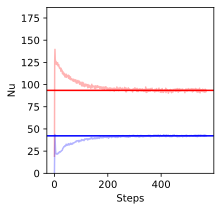

In [7]:
pts1 = statSteadSate(meta[2,:])
pts2 = statSteadSate(meta[3,:])
pts = np.max((pts1,pts2))
print('The Statistical Steady State Point is',pts)
print()
# pts = [1000]
nut,nub = compute_nua(meta,pts)
print('The Nusselt Number at the Top is',round(nut,3))
print('The Nusselt Number at the Bottom is',round(nub,3))

plt.figure()
plt.plot(meta[2,:],color='red', alpha=0.3);
plt.plot(meta[3,:], color='blue', alpha=0.3);
plt.axhline(nut,color='r');
plt.axhline(nub,color='b');
plt.ylim((nut-nut,nut+nut));

plt.ylabel('Nu')
plt.xlabel('Steps');

### Get Profile Averages

The Statistical Steady State Point is 221
4683.370235633738
5529.88424068768


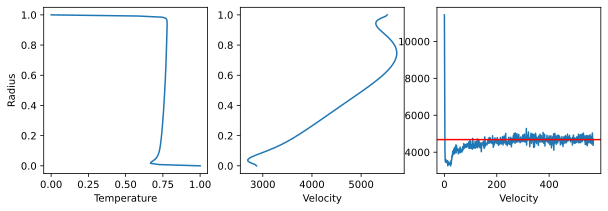

In [8]:
v_rms = rmsValue(Varray)
pts = statSteadSate(v_rms)
print('The Statistical Steady State Point is',pts)
Tave,Vave = profile_averages(Tarray,Varray,pts)
final_V_rms = np.mean(v_rms[pts:])
final_V_surf = Vave[-1]

fig = plt.figure(figsize=(10,3))

ax1 = plt.subplot(131)
plt.plot(Tave,z)
ax1.set_ylabel('Radius')
ax1.set_xlabel('Temperature')

ax2 = plt.subplot(132)
plt.plot(Vave,z)
ax2.set_xlabel('Velocity');

ax3 = plt.subplot(133)
plt.plot(v_rms)
ax3.set_xlabel('Velocity');
plt.axhline(final_V_rms,color='r');
print(final_V_rms)
print(final_V_surf)

# Save to file the profiles, Z, and Nu's

In [9]:
np.savetxt(full_path+'\\Radius_Test1.txt',z)
np.savetxt(full_path+'\\Temperature.txt',Tave)
np.savetxt(full_path+'\\RMS_Velocity.txt',Vave)

file = open(nu_path+"\\nuTop.txt", "a")
str = repr(nut)
file.write(str+'\n')
file.close()

file = open(nu_path+"\\nuBot.txt", "a")
str = repr(nub)
file.write(str+'\n')
file.close()

file = open(nu_path+"\\vrms.txt", "a")
str = repr(final_V_rms)
file.write(str+'\n')
file.close()

file = open(nu_path+"\\h.txt", "a")
str = h.split('H', 2)[1]
file.write(str+'\n')
file.close()

file = open(nu_path+"\\surface.txt", "a")
str = repr(final_V_surf)
file.write(str+'\n')
file.close()